# FMR

In this tutorial we will use the FMR standard problem as an example to show how to use the FMR functionality in `mag2exp`.

For more in-depth details of running the FMR standard problem in Ubermag please see [Tutorial for Standard Problem FMR](https://ubermag.github.io/examples/notebooks/10-tutorial-standard-problem-fmr.html).

## Setting up and running the micromagnetic simulation
In this first cell, we set up the micromagnetic simulation as detailed in the tutorial. This involves minimising the energy then applying a slight perturbation to the direction of the applied field and letting the system relax. 

Note: This simulation may take a while to complete.

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

lx = ly = 120e-9  # x and y dimensions of the sample(m)
lz = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
H = 8e4 * np.array([0.81345856316858023, 0.58162287266553481, 0.0])
alpha = 0.008  # Gilbert damping
gamma0 = 2.211e5

# Define the system
mesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=(dx, dy, dz))
system = mm.System(name="stdprobfmr")
system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=H)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)
system.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=Ms)

# Minimize the energy
md = oc.MinDriver()
md.drive(system)

# Change external magnetic field.
H = 8e4 * np.array([0.81923192051904048, 0.57346234436332832, 0.0])
system.energy.zeeman.H = H

# Let the system relax
T = 20e-9
n = 4000
td = oc.TimeDriver()
td.drive(system, t=T, n=n)

Running OOMMF (ExeOOMMFRunner)[2025-02-28T17:00:05]... (0.8 s)
Running OOMMF (ExeOOMMFRunner)[2025-02-28T17:00:06]... (145.2 s)


Now that we have run the simulation we can see what modes were present when running the `TimeDriver`.

## Analysing the FMR signal
Firstly we will load the data using `micromagneticdata`.

We can see that two drives have been run - the `MinDriver` and the `TimeDriver`.

In [2]:
import micromagneticdata as mdata

data = mdata.Data("stdprobfmr")
data.info

,drive_number,date,time,start_time,adapter,adapter_version,driver,end_time,elapsed_time,success,t,n
0,0,2025-02-28,17:00:05,2025-02-28T17:00:05,oommfc,0.64.1,MinDriver,2025-02-28T17:00:06,00:00:02,True,NaN,NaN
1,1,2025-02-28,17:00:06,2025-02-28T17:00:06,oommfc,0.64.1,TimeDriver,2025-02-28T17:02:31,00:02:26,True,2.000000e-08,4000.0


We are interested in the `Timedriver` so we will select this drive and use this for our calculations.

In [3]:
drive = data[-1]

We can import `mag2exp` and use the built in `ringdown` function in the `fmr` module to obtain the spatially resolved power and phase spectra.

Note: This can be computationally heavy and may take time depending on the size of the simulation.

We can also provide and optional `init_field` argument which takes a `discretisedfield.Field` object and subtracts it from each timestep of the micromagnetic drive.

In [4]:
import mag2exp

power, phase = mag2exp.fmr.ringdown(drive)

Both `power` and `phase` are `xarray.DataArray` objects, allowing us to use their built-in capabilities.

For example, a common quantity to plot is the power spectra for the whole of the sample as a function of frequency. To do this, lets look at the mean `z` component of the power spectra.

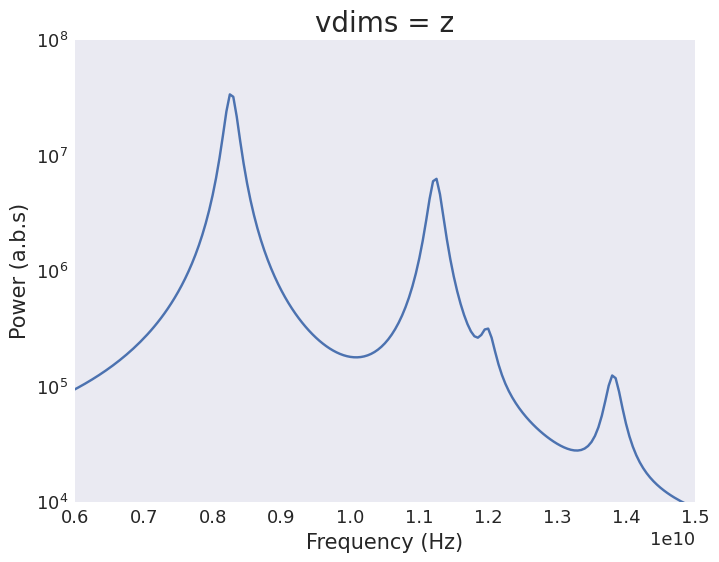

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Take the mean, select the z component and plot the xarray
power.mean(dim=("x", "y", "z")).sel(vdims="z").plot(ax=ax)

# Set log scale for y-axis
ax.set_yscale("log")

# Set axis labels
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (a.b.s)")

# Set axis limits
ax.set_xlim([6e9, 15e9])
ax.set_ylim([1e4, 1e8])

plt.show()

This closely mimics what we see in experiments. However, we can go a step further and look at the spatially resolved power dissipation. To do that we will select a particular frequency corresponding to a peak in out spectra, a plane (in this example `z=0`), and one of the `vdims`.

From this we can see that a lot of power is lost in the top left and bottom left corners at this frequency.

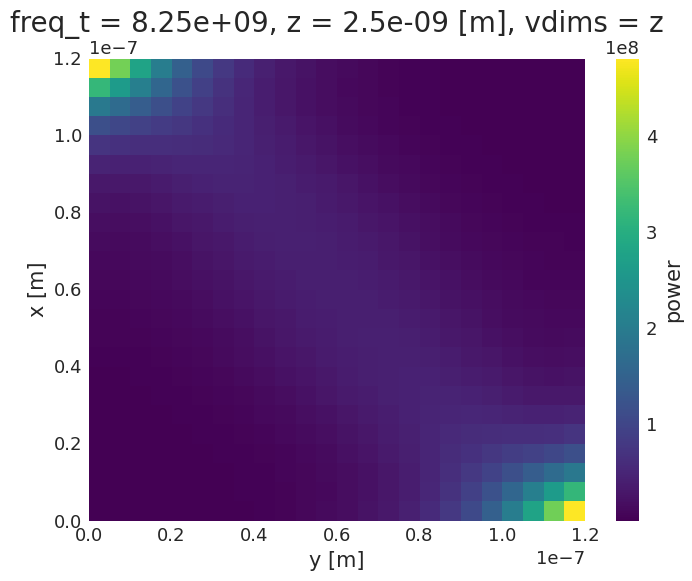

In [6]:
selection = {"freq_t": 8.25e9, "z": 0}
power.sel(selection, method="nearest").sel(vdims="z").plot()

We can also plot the phase using the same method.

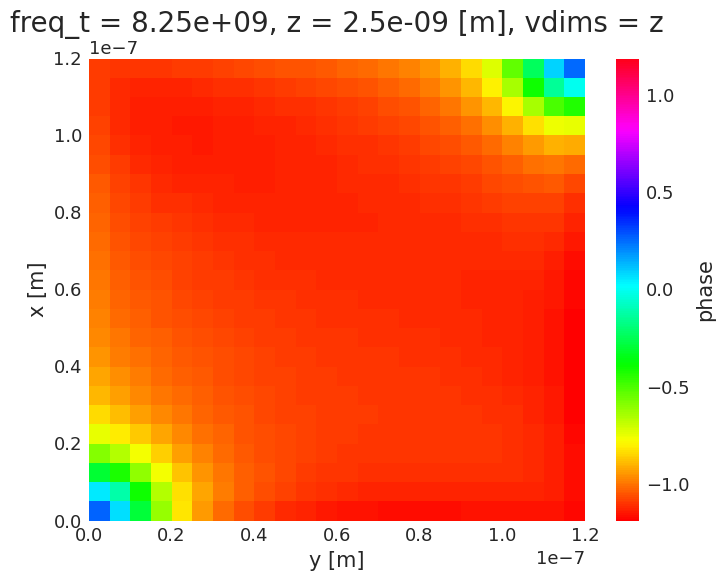

In [7]:
phase.sel(selection, method="nearest").sel(vdims="z").plot(cmap="hsv")

We can also use `hvplot` functionality to visualise the spatially resolved power spectra. This way we can move the slider to particular frequencies and visualise the spatially resolved power.

To do this we need to import `hvplot.xarray`, this gives our `xarray` the additional plotting functionality.

In [8]:
import hvplot.xarray  # noqa: F401

power.hvplot.image(x="x", y="y", colorbar=True, aspect="equal")

BokehModel(combine_events=True, render_bundle={'docs_json': {'7533cc6a-5cf9-4681-8410-ff53526f9681': {'version…

and also the spatially resolved phase.

In [9]:
phase.hvplot.image(
    x="x", y="y", colorbar=True, cmap="hsv", clim=(-np.pi, np.pi), aspect="equal"
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a526ac6c-a929-4698-9202-8c3581039aeb': {'version…

Clean up system at the end of the tutorial.

In [10]:
# oc.delete(system)